In [1]:
from os import environ

environ['optimizer'] = 'Adam'
environ['num_workers']= '2'
environ['batch_size']= '8192'
environ['n_epochs']= '1500'
environ['batch_norm']= 'True'
environ['loss_func']='MAPE'
environ['layers'] = '600 350 200 180'
environ['dropouts'] = '0.3 '*4
environ['log'] = 'False'
environ['weight_decay'] = '0.01'
environ['cuda_device'] ='cuda:0'
environ['dataset'] = '/data/scratch/mmerouani/data/speedup_dataset_research_batch1001-2000.pkl'

%run utils.ipynb

In [3]:
print("loading data")

train_dl, val_dl, test_dl = train_dev_split(dataset,val_size=10000, test_size=10000, batch_size=batch_size, num_workers=num_workers, log=log)
# train_dl, val_dl, test_dl = train_dev_split_filter(dataset,val_size=10000, test_size=10000, batch_size=batch_size, num_workers=num_workers, log=log, speedup_lo_bound=0.2)
db = fai.basic_data.DataBunch(train_dl, val_dl, test_dl, device=device)

print("data loaded")
print(val_dl.dataset.X.shape)

loading data


100%|██████████| 305800/305800 [09:20<00:00, 545.50it/s] 


data loaded
(305800, 3592)


In [4]:
input_size = train_dl.dataset.X.shape[1]
output_size = train_dl.dataset.Y.shape[1]

model = None 

if batch_norm:
    model = Model_BN_ELU(input_size, output_size, hidden_sizes=layers_sizes, drops=drops)
else:
    model = Model(input_size, output_size)

# model = nn.DataParallel(model)
# model.to(device)

if loss_func == 'MSE':
    criterion = nn.MSELoss()
else:
    criterion = mape_criterion

l = fai.basic_train.Learner(db, model, loss_func=criterion, metrics=[mape_criterion, rmse_criterion],
                            callback_fns=[partial(EarlyStoppingCallback, mode='min', 
                            monitor='mape_criterion', min_delta=0, patience=150)],silent=True)

if optimizer == 'SGD':
    l.opt_func = optim.SGD 
    

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


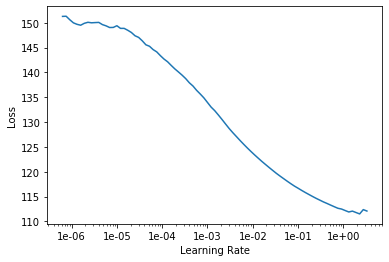

In [5]:
l.lr_find()
l.recorder.plot()

In [6]:
lr = 1e-02

In [7]:
l.fit_one_cycle(1500, lr)

Epoch 660: early stopping


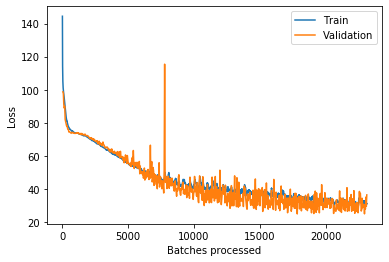

In [8]:
l.recorder.plot_losses()

In [ ]:
l.save(f"speedup_{optimizer}_batch_norm_{batch_norm}_{loss_func}_nlayers_{len(layers_sizes)}_log_{log}_batch1001-2000_ELU")

In [13]:
val_df = get_results_df(val_dl, l.model)
train_df = get_results_df(train_dl, l.model)
test_df=get_results_df(test_dl, l.model)

In [14]:
test_df.describe()

,index,prediction,target,abs_diff,APE,SMAPE,interchange,tile,unroll
count,10000.00000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4999.50000,0.401473,0.438427,7.721746e-02,24.536396,25.908989,0.757900,0.940400,0.750000
std,2886.89568,0.342628,0.384616,1.212221e-01,34.472652,32.096619,0.428376,0.236756,0.433034
min,0.00000,0.000000,0.004559,8.344650e-07,0.000079,0.000079,0.000000,0.000000,0.000000
25%,2499.75000,0.080136,0.086719,1.135659e-02,6.358892,6.396956,1.000000,1.000000,0.750000
50%,4999.50000,0.281474,0.309265,3.745474e-02,14.694213,15.106338,1.000000,1.000000,1.000000
75%,7499.25000,0.722925,0.775881,9.714109e-02,29.855874,31.719110,1.000000,1.000000,1.000000
max,9999.00000,1.264980,2.645030,1.504885e+00,509.495300,200.000015,1.000000,1.000000,1.000000


In [15]:
val_df.describe()

,index,prediction,target,abs_diff,APE,SMAPE,interchange,tile,unroll
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,14999.50000,0.392823,0.434748,0.090022,22.633327,25.077196,0.782900,0.947300,0.750000
std,2886.89568,0.331842,0.526266,0.353471,27.143410,32.464207,0.412292,0.223445,0.433034
min,10000.00000,0.000000,0.004063,0.000003,0.000650,0.000650,0.000000,0.000000,0.000000
25%,12499.75000,0.076076,0.088260,0.009691,5.891518,5.908508,1.000000,1.000000,0.750000
50%,14999.50000,0.314611,0.323237,0.033802,13.292280,13.411684,1.000000,1.000000,1.000000
75%,17499.25000,0.679467,0.683457,0.085446,28.448272,29.197307,1.000000,1.000000,1.000000
max,19999.00000,1.406221,6.865816,5.642678,367.176056,200.000015,1.000000,1.000000,1.000000


In [16]:
train_df.describe()

,index,prediction,target,abs_diff,APE,SMAPE,interchange,tile,unroll
count,285800.000000,285800.000000,285800.000000,2.858000e+05,285800.000000,285800.000000,285800.000000,285800.000000,285800.000000
mean,162899.500000,0.391860,0.414619,4.910665e-02,12.998473,14.676644,0.768034,0.944097,0.750000
std,82503.497805,0.330325,0.446321,2.758215e-01,15.157892,22.287466,0.422088,0.229734,0.433013
min,20000.000000,0.000000,0.002826,8.195639e-08,0.000062,0.000062,0.000000,0.000000,0.000000
25%,91449.750000,0.082772,0.089102,6.069705e-03,3.807428,3.813382,1.000000,1.000000,0.750000
50%,162899.500000,0.303796,0.313525,1.949441e-02,8.587076,8.675624,1.000000,1.000000,1.000000
75%,234349.250000,0.687946,0.700698,5.104748e-02,16.477762,16.989822,1.000000,1.000000,1.000000
max,305799.000000,1.406889,26.579260,2.563630e+01,351.916443,200.000015,1.000000,1.000000,1.000000


In [17]:
gdf_t=pd.DataFrame(train_df.groupby(['name']).mean())
gdf_v=pd.DataFrame(val_df.groupby(['name']).mean())

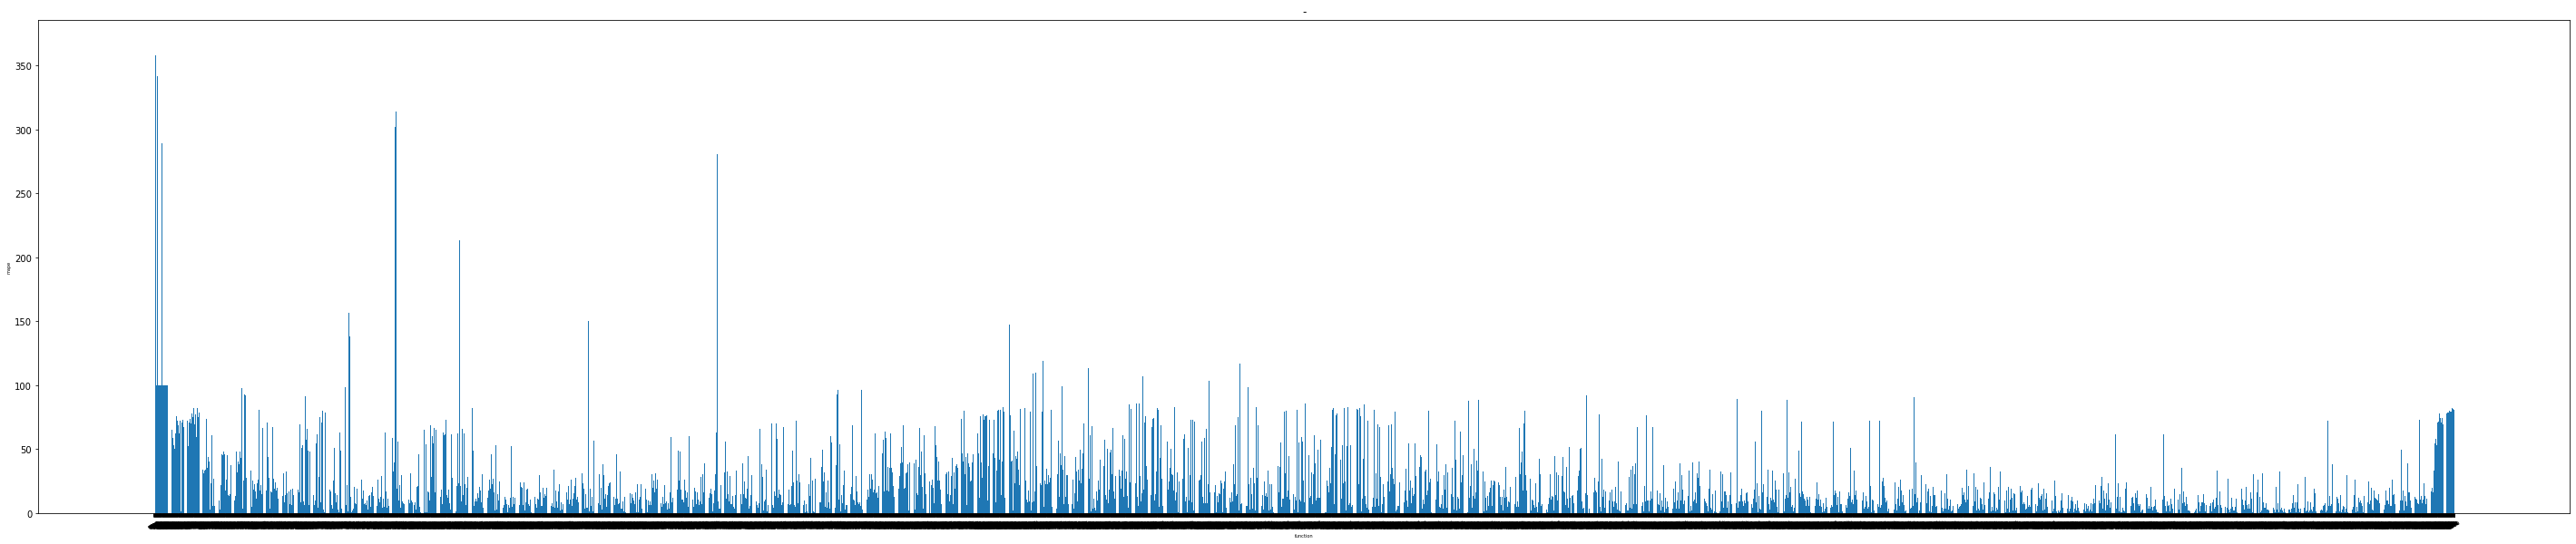

In [18]:
sorted_df=val_df.sort_values(by=["target"])
label=list(sorted_df.index)
mape=sorted_df['APE']
index = np.arange(len(label))
plt.figure(figsize=(50,10))
plt.bar(index, mape)
plt.xlabel('function', fontsize=5)
plt.ylabel('mape', fontsize=5)
plt.xticks(index, label, fontsize=5, rotation=30)
plt.title('-')
plt.show()

In [ ]:
sorted_df=train_df.sort_values(by=["target"])
label=list(sorted_df.index)
mape=sorted_df['APE']
index = np.arange(len(label))
plt.figure(figsize=(50,10))
plt.bar(index, mape)
plt.xlabel('function', fontsize=5)
plt.ylabel('mape', fontsize=5)
plt.xticks(index, label, fontsize=5, rotation=30)
plt.title('-')
plt.show()

In [19]:
df = val_df
df[(df.interchange==0) & (df.unroll == 0) & (df.tile == 0)][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,32.000000,32.0,32.000000,32.000000
mean,0.960304,1.0,0.068022,6.802162
std,0.141534,0.0,0.129932,12.993227
min,0.311098,1.0,0.003884,0.388354
25%,0.962318,1.0,0.015251,1.525092
50%,0.987631,1.0,0.026891,2.689058
75%,1.012899,1.0,0.050581,5.058101
max,1.219750,1.0,0.688902,68.890228


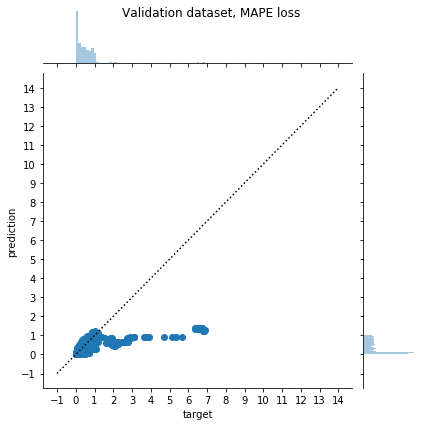

In [20]:
df1 = val_df[(df.interchange==0) & (df.unroll == 0) & (df.tile == 0)]
#joint_plot(df1, f"Validation dataset, {loss_func} loss")
df2 = val_df
joint_plot(df2, f"Validation dataset, {loss_func} loss")

In [21]:
df_ = val_df.sort_values(by=["APE"])

df_['x'] = range(len(df_))

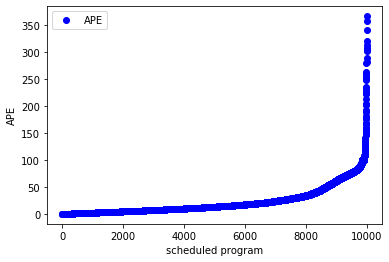

In [22]:
plt.plot('x', 'APE', 'bo', data=df_)


plt.xlabel('scheduled program')
plt.ylabel('APE')
plt.legend()

In [ ]:
l = l.load(f"speedup_{optimizer}_batch_norm_{batch_norm}_{loss_func}_nlayers_{len(layers_sizes)}_log_{log}_batch1001-2000_ELU")